In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 数据集路径
DATA_ROOT = r"F:\resource\data\airbusship"
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train_v2")
TEST_IMG_DIR = os.path.join(DATA_ROOT, "test_v2")
CSV_PATH = os.path.join(DATA_ROOT, "train_ship_segmentations_v2.csv")

print("=" * 50)
print("Airbus Ship 数据集分析")
print("=" * 50)

Airbus Ship 数据集分析


In [4]:
print("\n【1. 加载标注文件】")
df = pd.read_csv(CSV_PATH)
print(f"总标注数: {len(df)}")
print(f"列名: {df.columns.tolist()}")
print(f"\n前5行数据:")
print(df.head())


【1. 加载标注文件】
总标注数: 231723
列名: ['ImageId', 'EncodedPixels']

前5行数据:
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...



【2. 分析有船/无船图片分布】
有船的图片数: 81723
无船的图片数: 150000
有船图片占比: 35.27%


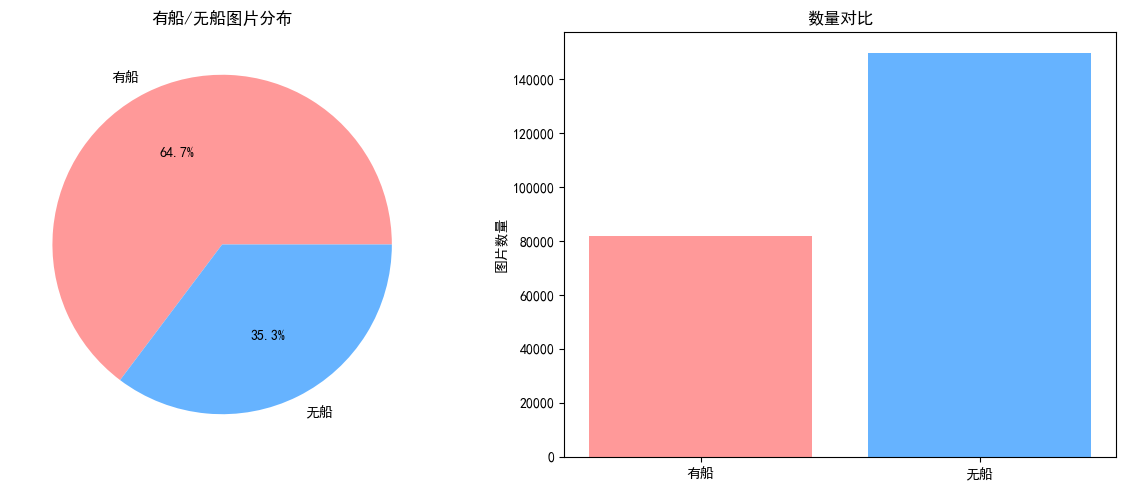

In [5]:
print("\n【2. 分析有船/无船图片分布】")
df['has_ship'] = df['EncodedPixels'].notna()
ship_counts = df['has_ship'].value_counts()
print(f"有船的图片数: {ship_counts.get(True, 0)}")
print(f"无船的图片数: {ship_counts.get(False, 0)}")
print(f"有船图片占比: {ship_counts.get(True, 0) / len(df) * 100:.2f}%")

# 可视化分布
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#ff9999', '#66b3ff']

# 饼图
axes[0].pie(ship_counts, labels=['有船', '无船'], autopct='%1.1f%%', colors=colors)
axes[0].set_title('有船/无船图片分布')

# 柱状图
axes[1].bar(['有船', '无船'], [ship_counts.get(True, 0), ship_counts.get(False, 0)], color=colors)
axes[1].set_title('数量对比')
axes[1].set_ylabel('图片数量')
plt.tight_layout()
plt.show()


【3. 分析每张图片的船只数量】
平均每张图片船只数: 0.42
最大船只数: 15
船只数量分布:
EncodedPixels
0    150000
1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
Name: count, dtype: int64


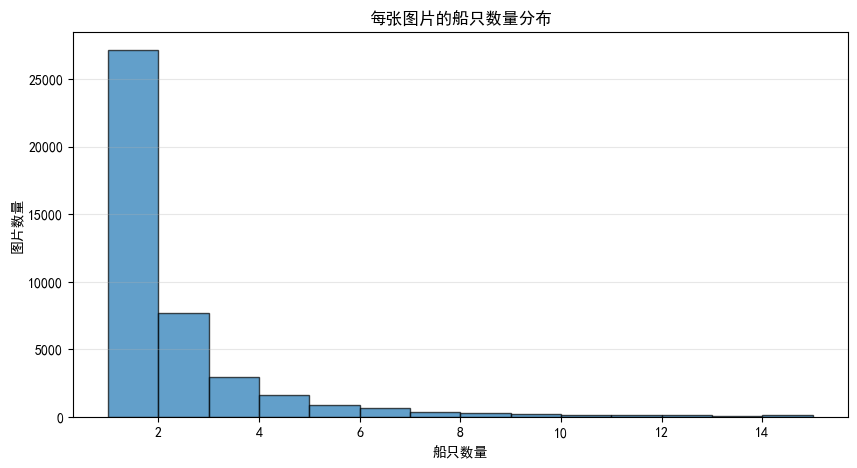

In [6]:
# 3. 分析每张图片的船只数量
print("\n【3. 分析每张图片的船只数量】")
ships_per_image = df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.notna().sum())
print(f"平均每张图片船只数: {ships_per_image.mean():.2f}")
print(f"最大船只数: {ships_per_image.max()}")
print(f"船只数量分布:")
print(ships_per_image.value_counts().sort_index().head(10))

plt.figure(figsize=(10, 5))
plt.hist(ships_per_image, bins=range(1, 16), edgecolor='black', alpha=0.7)
plt.xlabel('船只数量')
plt.ylabel('图片数量')
plt.title('每张图片的船只数量分布')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [8]:
print("\n【4. 检查图片文件】")
train_images = os.listdir(TRAIN_IMG_DIR)
test_images = os.listdir(TEST_IMG_DIR)
print(f"训练文件夹图片数: {len(train_images)}")
print(f"测试文件夹图片数: {len(test_images)}")
print(f"CSV中唯一图片数: {df['ImageId'].nunique()}")


【4. 检查图片文件】
训练文件夹图片数: 192556
测试文件夹图片数: 15606
CSV中唯一图片数: 192556


In [7]:
print("\n【5. 分析图片尺寸】")
sample_images = train_images[:100]
image_sizes = []
for img_name in sample_images:
  img_path = os.path.join(TRAIN_IMG_DIR, img_name)
  with Image.open(img_path) as img:
      image_sizes.append(img.size)

image_sizes = np.array(image_sizes)
unique_sizes = np.unique(image_sizes, axis=0)
print(f"采样图片数量: {len(sample_images)}")
print(f"图片尺寸: {unique_sizes}")


【5. 分析图片尺寸】


NameError: name 'train_images' is not defined

In [10]:
# 6. RLE解码函数
def rle_decode(mask_rle, shape=(768, 768)):
  """将RLE编码解码为二值掩码"""
  if pd.isna(mask_rle):
      return np.zeros(shape, dtype=np.uint8)

  s = mask_rle.split()
  starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
  starts -= 1
  ends = starts + lengths

  mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
  for start, end in zip(starts, ends):
      mask[start:end] = 1

  return mask.reshape(shape).T


【7. 可视化样本图片和掩码】


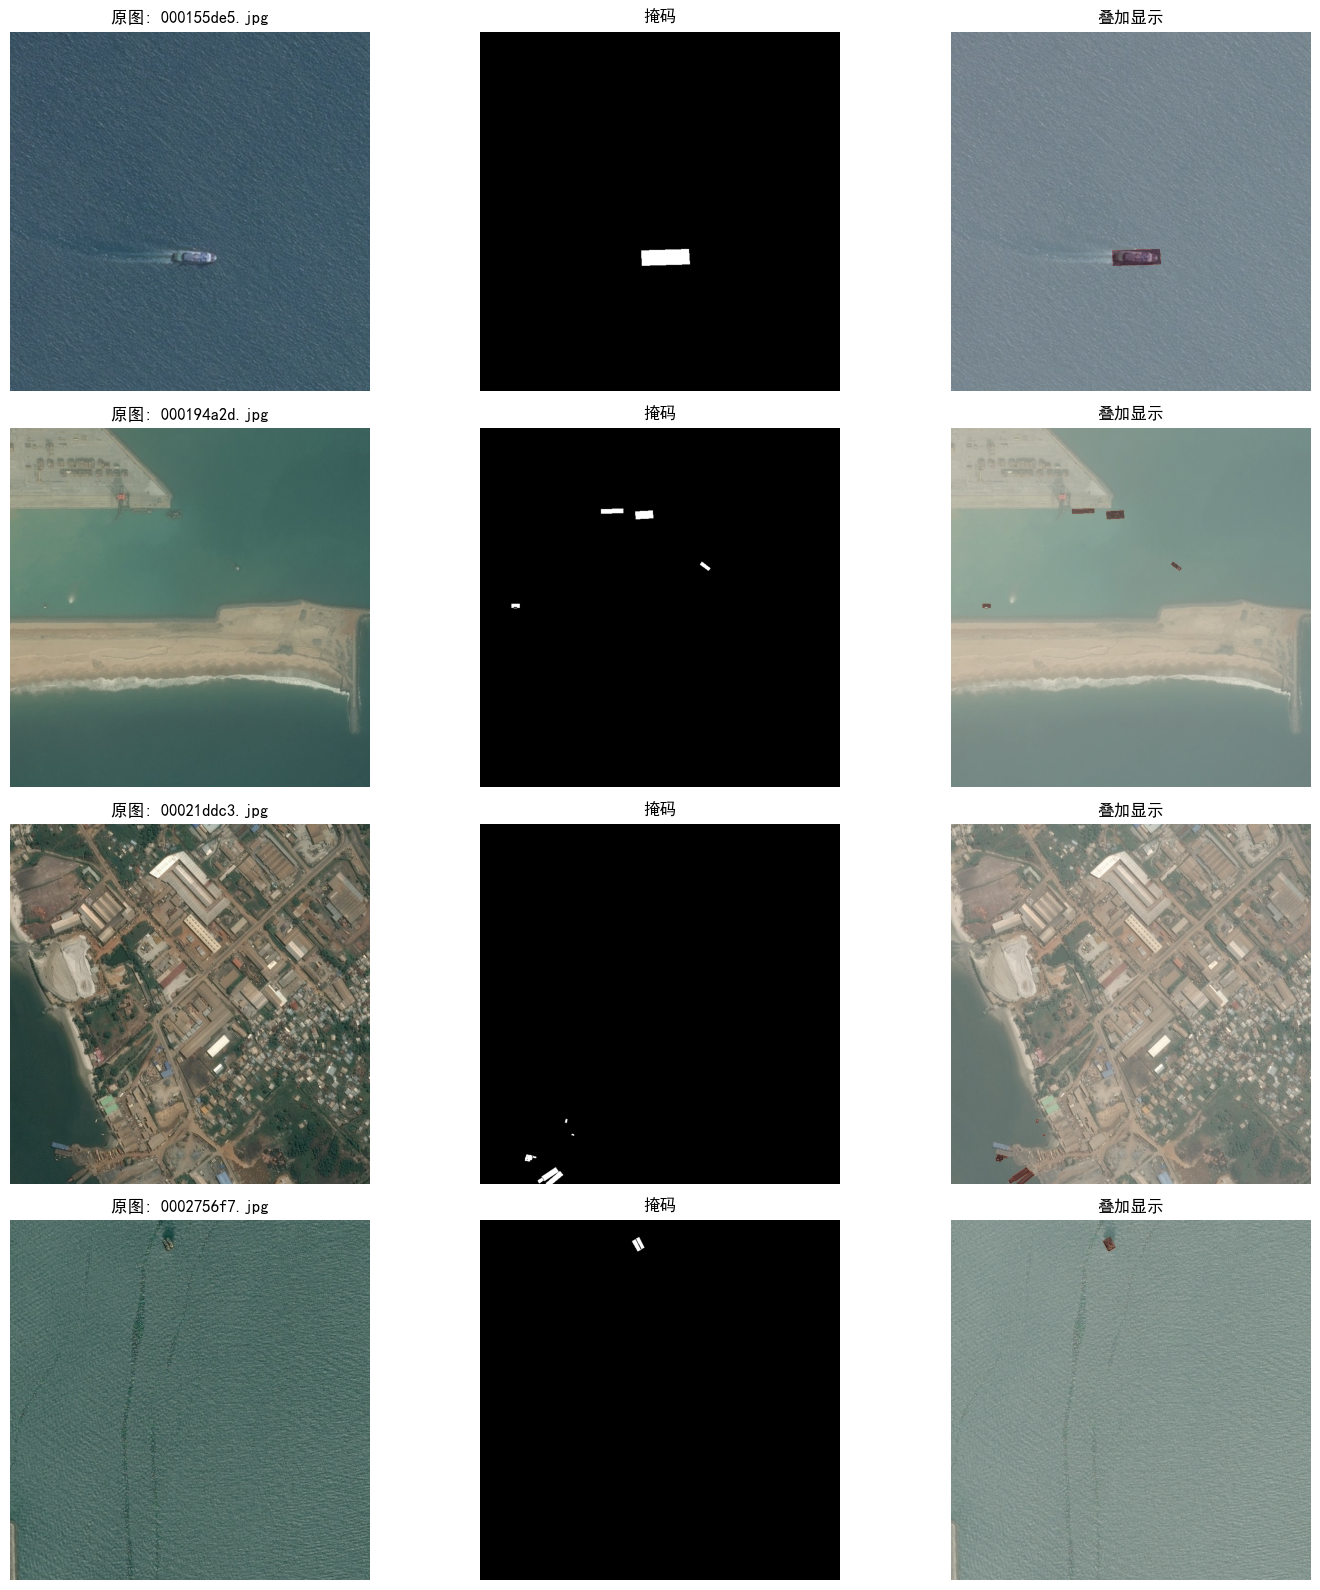

In [11]:
  # 7. 可视化样本
  print("\n【7. 可视化样本图片和掩码】")
  def visualize_samples(num_samples=4):
      """可视化样本图片和对应的掩码"""
      # 选择有船的图片
      ship_images = df[df['EncodedPixels'].notna()]['ImageId'].unique()[:num_samples]

      fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
      if num_samples == 1:
          axes = axes.reshape(1, -1)

      for idx, img_id in enumerate(ship_images):
          # 读取图片
          img_path = os.path.join(TRAIN_IMG_DIR, img_id)
          img = Image.open(img_path)

          # 获取该图片的所有掩码
          img_masks = df[df['ImageId'] == img_id]['EncodedPixels'].values

          # 合并所有掩码
          combined_mask = np.zeros((768, 768), dtype=np.uint8)
          for mask_rle in img_masks:
              if pd.notna(mask_rle):
                  mask = rle_decode(mask_rle)
                  combined_mask = np.maximum(combined_mask, mask)

          # 显示
          axes[idx, 0].imshow(img)
          axes[idx, 0].set_title(f'原图: {img_id}')
          axes[idx, 0].axis('off')

          axes[idx, 1].imshow(combined_mask, cmap='gray')
          axes[idx, 1].set_title('掩码')
          axes[idx, 1].axis('off')

          axes[idx, 2].imshow(img)
          axes[idx, 2].imshow(combined_mask, alpha=0.3, cmap='Reds')
          axes[idx, 2].set_title('叠加显示')
          axes[idx, 2].axis('off')

      plt.tight_layout()
      plt.show()

  visualize_samples(4)


【8. 分析船只掩码面积】
平均掩码面积(像素): 1318
最小掩码面积: 2
最大掩码面积: 18480


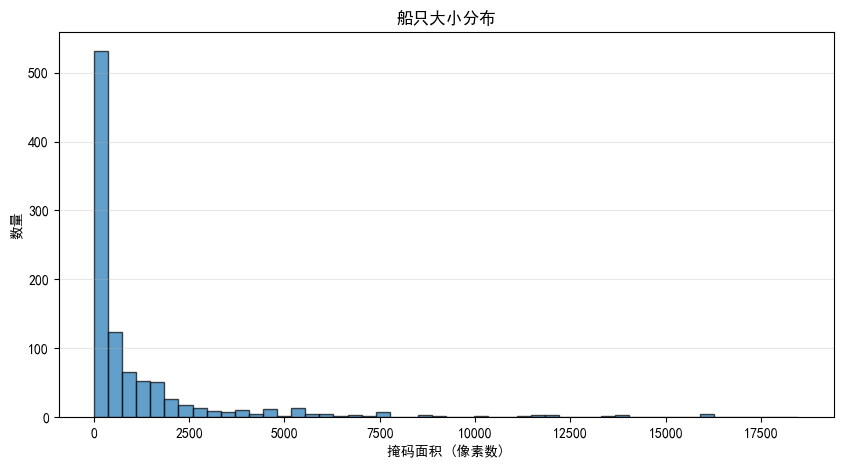


数据分析完成!


In [12]:
print("\n【8. 分析船只掩码面积】")
mask_areas = []
for mask_rle in df[df['EncodedPixels'].notna()]['EncodedPixels'].values[:1000]:
  mask = rle_decode(mask_rle)
  mask_areas.append(np.sum(mask))

mask_areas = np.array(mask_areas)
print(f"平均掩码面积(像素): {mask_areas.mean():.0f}")
print(f"最小掩码面积: {mask_areas.min()}")
print(f"最大掩码面积: {mask_areas.max()}")

plt.figure(figsize=(10, 5))
plt.hist(mask_areas, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('掩码面积 (像素数)')
plt.ylabel('数量')
plt.title('船只大小分布')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n" + "=" * 50)
print("数据分析完成!")
print("=" * 50)